# K-means 예제

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs      

In [2]:
# 샘플 데이터 생성

np.random.seed(0)

centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

In [3]:
# k-means clustering 수행

k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time() # 시간을 체크하기 위한 시작 시간 설정
k_means.fit(X)
t_normal = time.time() - t0 # 학습 후 시간에서 시작 시간을 빼서, 경과한 시간을 기록

In [4]:
# MiniBatch K-means clustering 수행

mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=45,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

In [5]:
k_means_cluster_centers = k_means.cluster_centers_ # cluster의 중심점들

order = pairwise_distances_argmin(k_means.cluster_centers_, # distance가 최소가 되는 것
                                  mbk.cluster_centers_) # 의미: k와 mbk의 cluster의 클러스터가 형성된 클러스터가 다름. 따라서 가장 가까운 센터의 클러스터를 같은 클러스터로 매칭시켜주기 위해서 순서(order)를 구한 것

mbk_means_cluster_centers = mbk.cluster_centers_[order] # kmeans cluster의 순서에 맞게 mini batch kmeans cluster의 순서를 바꾸어 주는 것

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers) # 입력 데이터에 대해서 가장 가까운 center를 찾아 cluster로 설정
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers) 

In [6]:
k_means_cluster_centers

array([[-1.07262225, -1.00554224],
       [ 1.07510478, -1.06937206],
       [ 0.96786467,  1.0173955 ]])

In [7]:
k_means_labels

array([1, 0, 1, ..., 0, 0, 2])

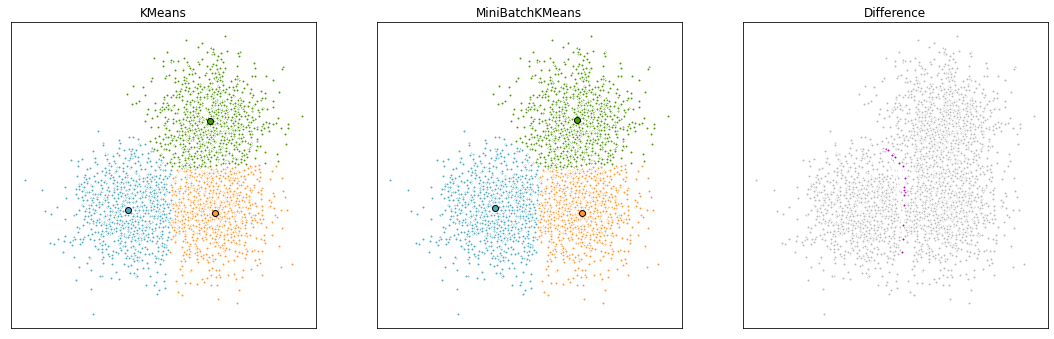

In [8]:
# 그래프로 그리기

fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06'] # hex code

# KMeans
ax = fig.add_subplot(1, 3, 1) # 1 row, 3 col의 그래프 중 첫번째 그래프
for k, color in zip(range(n_clusters), colors): # cluster의 갯수만큼 for loop, color도 동시에 for loop
    my_members = k_means_labels == k # cluster 번호와 동일한 label만 이번의 member로 설정
    cluster_center = k_means_cluster_centers[k] # cluster의 중심값을 가져오고,
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', #해당 cluster의 데이터들 그리기 (색 주의)
            markerfacecolor=color, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=color, # 중심점을 그리기
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2) # 1 row, 3 col의 그래프 중 두번째 그래프
for k, color in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=color, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=color,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())

different = (mbk_means_labels == 4) # 배열의 모든 값을 False로 시작! (데이터 길이가 같게 쉽게 생성)
ax = fig.add_subplot(1, 3, 3) # 1 row, 3 col의 그래프 중 세번째 그래프

for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == k)) # cluster 별로 돌면서, kmeans와 mini batch kmeans가 예측한 class가 다른 것만 dfferent에 추가

identic = np.logical_not(different) # 다른게 True로 되어있는데, 같은 것을 그래프에 그리기 위해서 not 연산을 통해 반대로 바꿔줌
ax.plot(X[identic, 0], X[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

In [9]:
print(t_normal, t_mini_batch) # 20% 정도의 속도 향상

0.11148619651794434 0.07391595840454102


In [10]:
print('n_clusters:', n_clusters)
print('colors:', colors)
print()
for k, color in zip(range(n_clusters), colors): # 0, 1, 2
  print(k, color)

n_clusters: 3
colors: ['#4EACC5', '#FF9C34', '#4E9A06']

0 #4EACC5
1 #FF9C34
2 #4E9A06


In [11]:
print(k_means_labels)
print(k_means_labels == 0)

[1 0 1 ... 0 0 2]
[False  True False ...  True  True False]


In [12]:
different
identic = np.logical_not(different)
print(different)
print(identic)

[ True False False ... False False False]
[False  True  True ...  True  True  True]


In [13]:
# 정확도 계산 (잘못된)

kmeans_score = np.sum(k_means_labels == labels) / len(labels)
mbkmeans_score = np.sum(mbk_means_labels == labels) / len(labels)

print(kmeans_score)
print(mbkmeans_score)

0.05
0.048666666666666664


In [14]:
# 정확도 계산

order = pairwise_distances_argmin(centers, k_means.cluster_centers_)
k_means_cluster_centers = k_means.cluster_centers_[order]
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers) 

order = pairwise_distances_argmin(centers, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers) 

kmeans_score = np.sum(k_means_labels == labels) / len(labels)
mbkmeans_score = np.sum(mbk_means_labels == labels) / len(labels)

print(kmeans_score)
print(mbkmeans_score)

0.9006666666666666
0.8996666666666666


In [15]:
print(mbkmeans_score)
print("%.3f" % mbkmeans_score)
print("%.2f" % round(mbkmeans_score, 2))
print("{:.2f}".format(mbkmeans_score)) 

0.8996666666666666
0.900
0.90
0.90


In [16]:
print(kmeans_score, mbkmeans_score)
print("%.2f %.2f" % (kmeans_score, mbkmeans_score)) #%c, %s, %i %f
print("%.2f %.2f" % (round(kmeans_score, 2), round(mbkmeans_score, 2)))
print("{:.2f} {:.2f}".format(kmeans_score, mbkmeans_score)) # <- 개인적으로 가장 선호하는 방법, 하지만 모두 읽고 이해할 수 있어야함!

0.9006666666666666 0.8996666666666666
0.90 0.90
0.90 0.90
0.90 0.90


In [17]:
print(kmeans_score, '%', mbkmeans_score, '%')
print("%.2fscore%% %.2f%%" % (kmeans_score, mbkmeans_score)) #%c, %s, %i %f
print("%.2f%% %.2f%%" % (round(kmeans_score, 2), round(mbkmeans_score, 2)))
print("{:.2f}% {:.2f}%".format(kmeans_score, mbkmeans_score)) # <- 개인적으로 가장 선호하는 방법, 하지만 모두 읽고 이해할 수 있어야함!

0.9006666666666666 % 0.8996666666666666 %
0.90score% 0.90%
0.90% 0.90%
0.90% 0.90%


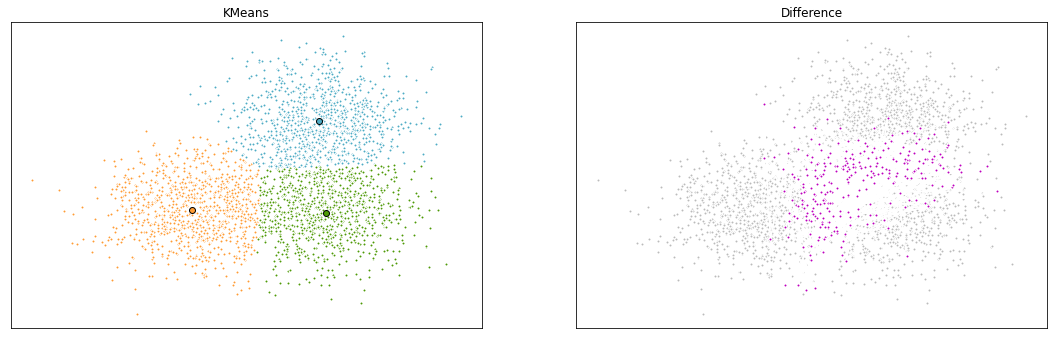

In [18]:
# 그래프로 그리기

fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06'] # hex code

# KMeans
ax = fig.add_subplot(1, 2, 1) # 1 row, 3 col의 그래프 중 첫번째 그래프
for k, color in zip(range(n_clusters), colors): # cluster의 갯수만큼 for loop, color도 동시에 for loop
    my_members = k_means_labels == k # cluster 번호와 동일한 label만 이번의 member로 설정
    cluster_center = k_means_cluster_centers[k] # cluster의 중심값을 가져오고,
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', #해당 cluster의 데이터들 그리기 (색 주의)
            markerfacecolor=color, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=color, # 중심점을 그리기
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())

different = (mbk_means_labels == 4) # 배열의 모든 값을 False로 시작! (데이터 길이가 같게 쉽게 생성)
ax = fig.add_subplot(1, 2, 2) # 1 row, 3 col의 그래프 중 세번째 그래프

for k in range(n_clusters):
    different += ((k_means_labels == k) != (labels == k)) # cluster 별로 돌면서, kmeans와 mini batch kmeans가 예측한 class가 다른 것만 dfferent에 추가

identic = np.logical_not(different) # 다른게 True로 되어있는데, 같은 것을 그래프에 그리기 위해서 not 연산을 통해 반대로 바꿔줌
ax.plot(X[identic, 0], X[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()